## Imports and Set up


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# df = pd.read_csv("../data/flocking_250305.csv")
df = pd.read_csv("flocking_250305.csv")


Using device: cpu


## Prepare Data

In [2]:
# df["NeighborDiffSum"] = df["NeighborDiffSum"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["NeighborInfo"] = df["NeighborInfo"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["Angle"] = df["Angle"].astype(float)

"""
group data according to each time step
"""
grouped = df.groupby("Step").agg(list)
# neighbor_diff_sum = np.array(grouped["NeighborDiffSum"].to_list())  # Shape: (num_steps, num_agents, 2)
neighbor_info = np.array(grouped["NeighborInfo"].to_list())  # Shape: (num_steps, num_agents, 2)
angles = np.array(grouped["Angle"].to_list()).reshape(len(grouped), len(grouped.iloc[0]["Angle"]), 1)  # Shape: (num_steps, num_agents, 1)

"""
this makes sure angle difference wraps correctly within [-pi. pi]
"""
def angle_difference(theta2, theta1):
    return np.arctan2(np.sin(theta2 - theta1), np.cos(theta2 - theta1))
delta_angle = np.zeros_like(angles)
delta_angle[1:] = angle_difference(angles[1:], angles[:-1]) # Shape: (num_steps, num_agents, 1)

grouped["deltaAngle"] = delta_angle.reshape(len(grouped), -1).tolist()

# X_train, X_test, y_train, y_test = train_test_split(neighbor_diff_sum, delta_angle, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(neighbor_info, delta_angle, test_size=0.2, random_state=42)

# to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## For Debugging

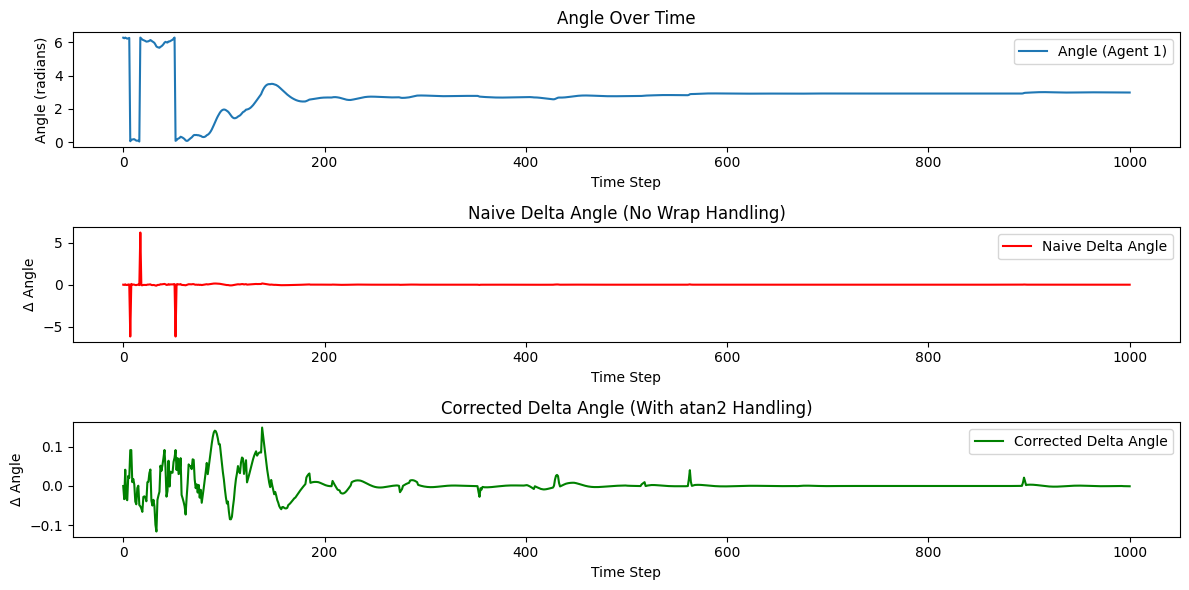

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Compute incorrect delta angles (naive subtraction)
naive_delta_angle = np.zeros_like(angles)
naive_delta_angle[1:] = angles[1:] - angles[:-1]

# Compute corrected delta angles (using atan2)
corrected_delta_angle = np.zeros_like(angles)
corrected_delta_angle[1:] = np.arctan2(np.sin(angles[1:] - angles[:-1]), np.cos(angles[1:] - angles[:-1]))

# Plot angles over time
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(angles[:, 1, 0], label="Angle (Agent 1)")
plt.xlabel("Time Step")
plt.ylabel("Angle (radians)")
plt.title("Angle Over Time")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(naive_delta_angle[:, 1, 0], label="Naive Delta Angle", color="red")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Naive Delta Angle (No Wrap Handling)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(corrected_delta_angle[:, 1, 0], label="Corrected Delta Angle", color="green")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Corrected Delta Angle (With atan2 Handling)")
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
angles_df = pd.DataFrame(angles.reshape(len(grouped), -1))  # col: agent number; row: timestep
delta_angle_df = pd.DataFrame(delta_angle.reshape(len(grouped), -1))  # Each column is an agent's deltaAngle

In [24]:
angles_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,5.631839,6.273073,0.407752,5.292951,2.151823,1.995323,3.392318,6.042263,3.504250,2.589889,...,3.921303,0.651842,1.641619,3.769175,0.044270,1.033349,3.329500,3.649356,1.860523,1.575105
1,5.746875,6.239681,0.377927,5.363699,2.169451,1.995323,3.371359,5.979910,3.549325,2.604798,...,3.908120,0.634191,1.788753,3.791404,0.186366,1.105915,2.974755,3.626389,1.809012,1.593346
2,5.832136,6.280926,0.378919,5.429038,2.166158,1.995323,3.371304,5.917134,3.588927,2.582808,...,3.898178,0.620421,1.886932,3.824070,0.108657,1.194121,2.830049,3.582289,1.779122,1.616862
3,5.900980,6.249076,0.396830,5.404799,2.143385,2.141878,3.366004,5.867871,3.575292,2.560711,...,3.886604,0.606202,1.997806,3.865156,0.197605,1.198668,2.829611,3.530607,1.748461,1.644976
4,5.956124,6.212957,0.432627,5.378357,2.109922,2.166982,3.355115,5.828726,3.552634,2.537338,...,3.874661,0.553913,2.074618,3.876666,0.281492,1.209762,2.838851,3.465823,1.733806,1.699896
5,6.031401,6.238444,0.473870,5.349604,2.121909,2.168171,3.349273,5.860545,3.525175,2.561716,...,3.857154,0.524030,2.160055,3.894320,0.374578,1.229100,2.911015,3.378925,1.697277,1.750783
6,6.021276,6.258536,0.496204,5.397585,2.061841,2.162592,3.342871,5.897353,3.632616,2.576388,...,3.828348,0.490427,2.249699,3.886297,0.420785,1.257320,2.967868,3.275484,1.595951,1.798656
7,6.005963,0.066167,0.499861,5.445594,2.000671,2.150235,3.324940,5.907821,3.717933,2.663584,...,3.827010,0.434347,2.336096,3.882845,0.445096,1.299425,2.931033,3.139747,1.507492,1.842521
8,5.985464,0.157119,0.515689,5.494920,1.934982,2.130281,3.320675,5.924987,3.838403,2.660788,...,3.850648,0.400970,2.416733,3.871587,0.466274,1.283427,2.939746,2.959909,1.517196,1.813829
9,6.005789,0.166870,0.517694,5.544558,1.879584,2.164975,3.315000,5.952615,3.906744,2.687186,...,3.896838,0.359669,2.474969,3.906296,0.446520,1.273064,2.945342,2.725738,1.537357,1.777547


In [22]:
delta_angle_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.115036,-0.033392,-0.029826,0.070749,0.017628,0.000000,-0.020959,-0.062353,0.045075,0.014909,...,-0.013183,-0.017651,0.147134,0.022229,0.142096,0.072566,-0.354745,-0.022967,-0.051511,0.018241
2,0.085261,0.041245,0.000992,0.065338,-0.003292,0.000000,-0.000055,-0.062775,0.039602,-0.021991,...,-0.009942,-0.013769,0.098180,0.032665,-0.077709,0.088206,-0.144705,-0.044100,-0.029890,0.023517
3,0.068844,-0.031850,0.017911,-0.024239,-0.022774,0.146555,-0.005299,-0.049264,-0.013634,-0.022097,...,-0.011574,-0.014220,0.110874,0.041086,0.088948,0.004546,-0.000438,-0.051681,-0.030661,0.028114
4,0.055144,-0.036118,0.035797,-0.026442,-0.033463,0.025104,-0.010889,-0.039145,-0.022658,-0.023373,...,-0.011943,-0.052289,0.076812,0.011511,0.083888,0.011095,0.009240,-0.064784,-0.014655,0.054920
5,0.075277,0.025486,0.041243,-0.028753,0.011988,0.001189,-0.005841,0.031818,-0.027460,0.024379,...,-0.017506,-0.029882,0.085437,0.017654,0.093086,0.019337,0.072163,-0.086899,-0.036529,0.050886
6,-0.010125,0.020093,0.022334,0.047980,-0.060069,-0.005579,-0.006403,0.036808,0.107442,0.014672,...,-0.028806,-0.033603,0.089644,-0.008023,0.046207,0.028221,0.056854,-0.103440,-0.101326,0.047873
7,-0.015312,0.090815,0.003657,0.048010,-0.061170,-0.012357,-0.017931,0.010469,0.085317,0.087196,...,-0.001338,-0.056080,0.086397,-0.003452,0.024311,0.042105,-0.036836,-0.135737,-0.088459,0.043865
8,-0.020499,0.090953,0.015828,0.049326,-0.065689,-0.019954,-0.004265,0.017166,0.120470,-0.002796,...,0.023637,-0.033377,0.080637,-0.011258,0.021178,-0.015999,0.008714,-0.179839,0.009704,-0.028692
9,0.020325,0.009751,0.002005,0.049638,-0.055398,0.034694,-0.005674,0.027628,0.068341,0.026398,...,0.046190,-0.041301,0.058236,0.034709,-0.019754,-0.010363,0.005596,-0.234171,0.020161,-0.036282


In [13]:
np.arctan2(-0.09105, 0.9958)

np.float64(-0.09118049177939738)

## Define Model

In [3]:
# define nn
hidden_size_1 = 16
hidden_size_2 = 8
hidden_size_3 = 4

model = nn.Sequential(
    nn.Linear(8, hidden_size_1),
    nn.ReLU(),
    nn.Linear(hidden_size_1, hidden_size_2),
    nn.ReLU(),
    nn.Linear(hidden_size_2, 1)
)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define Model

In [4]:
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor.view(-1, 8))
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.0138
Epoch [20/1000], Loss: 0.0072
Epoch [30/1000], Loss: 0.0056
Epoch [40/1000], Loss: 0.0043
Epoch [50/1000], Loss: 0.0035
Epoch [60/1000], Loss: 0.0031
Epoch [70/1000], Loss: 0.0028
Epoch [80/1000], Loss: 0.0026
Epoch [90/1000], Loss: 0.0024
Epoch [100/1000], Loss: 0.0023
Epoch [110/1000], Loss: 0.0021
Epoch [120/1000], Loss: 0.0020
Epoch [130/1000], Loss: 0.0019
Epoch [140/1000], Loss: 0.0018
Epoch [150/1000], Loss: 0.0016
Epoch [160/1000], Loss: 0.0015
Epoch [170/1000], Loss: 0.0014
Epoch [180/1000], Loss: 0.0013
Epoch [190/1000], Loss: 0.0013
Epoch [200/1000], Loss: 0.0012
Epoch [210/1000], Loss: 0.0012
Epoch [220/1000], Loss: 0.0011
Epoch [230/1000], Loss: 0.0011
Epoch [240/1000], Loss: 0.0011
Epoch [250/1000], Loss: 0.0010
Epoch [260/1000], Loss: 0.0010
Epoch [270/1000], Loss: 0.0010
Epoch [280/1000], Loss: 0.0010
Epoch [290/1000], Loss: 0.0010
Epoch [300/1000], Loss: 0.0009
Epoch [310/1000], Loss: 0.0009
Epoch [320/1000], Loss: 0.0009
Epoch [330/1000],

## Evaluate the model

In [5]:
with torch.no_grad():
    y_pred = model(X_test_tensor.view(-1, 8))
    test_loss = criterion(y_pred, y_test_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item():.4f}')
    print(y_pred)

Test Loss: 0.0007
tensor([[-0.0042],
        [ 0.0038],
        [-0.0019],
        ...,
        [-0.0326],
        [ 0.0110],
        [-0.0018]])


## Save the model

In [7]:
torch.save(model, '20250305_full_v2')